In [1]:
!pip install transformers torch pandas matplotlib seaborn scikit-learn openpyxl nltk


   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   ---------------------------------------- 8.1/8.1 MB 55.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/1.5 MB ? eta -:--:--
   ---------------------------------------- 1.5/1.5 MB 40.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 63.6 MB/s eta 0:00:00

   ----------------------------------------  0/11 [pyparsing]
   ------- --------------------------------  2/11 [fonttools]
   ------- --------------------------------  2/11 [fonttools]
   ------- --------------------------------  2/11 [fonttools]
   ------- --------------------------------  2/11 [fonttools]
   ------- --------------------------------  2/11 [fonttools]
   ------- --------------------------------  2/11 [fonttools]
   ------- --------------------------------  2/11 [fonttools]
   ------- --------------------------------  2/11 [fonttools]
   

In [2]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [13]:
import os, json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
import torch
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

# ======================== SETUP PATHS ========================
model_path = "fine_tuned_distilbert"

tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)

label_map_file = "label_mapping.json"  # ← Add this line

with open(label_map_file, "r") as f:
    id_to_label = {int(k): v for k, v in json.load(f).items()}

batch_folder = r"C:\Users\andre\Downloads\saved_data"  # <-- Change this to your folder name

# ========================== LOAD MODEL ==========================
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

with open(label_map_file, "r") as f:
    id_to_label = {int(k): v for k, v in json.load(f).items()}

# ========================== LOAD JSON FILES ==========================
all_records = []
for file in os.listdir(batch_folder):
    if file.endswith(".txt"):
        with open(os.path.join(batch_folder, file), encoding="utf-8") as f:
            for line in f:
                if line.strip():
                    record = json.loads(line)
                    if "summary" in record:
                        all_records.append(record)

print(f"✅ Loaded {len(all_records)} records.")

# ========================== RUN INFERENCE ==========================
titles, summaries, predicted_labels = [], [], []

for rec in all_records:
    summary = rec["summary"]
    title = rec.get("title", "")
    
    titles.append(title)
    summaries.append(summary)

    inputs = tokenizer(summary, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits
        pred = torch.argmax(logits, dim=-1).item()
        predicted_labels.append(id_to_label[pred])

# ========================== SAVE TO EXCEL ==========================
df = pd.DataFrame({
    "Title": titles,
    "Summary": summaries,
    "Predicted_Category": predicted_labels
})
df.to_excel("llm_predictions.xlsx", index=False)
print("✅ Excel file saved as llm_predictions.xlsx")

# ========================== VISUALIZATION - CATEGORY DISTRIBUTION ==========================
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="Predicted_Category", order=df["Predicted_Category"].value_counts().index)
plt.xticks(rotation=45)
plt.title("Article Distribution per Predicted Category")
plt.xlabel("Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# ========================== VISUALIZATION - TOP KEYWORDS PER CATEGORY ==========================
def get_top_keywords(texts, n=10):
    all_words = []
    for text in texts:
        words = word_tokenize(text.lower())
        words = [w for w in words if w.isalpha() and w not in stop_words]
        all_words.extend(words)
    return pd.Series(Counter(all_words)).nlargest(n)

top_keywords = {}
for cat in df["Predicted_Category"].unique():
    summaries_cat = df[df["Predicted_Category"] == cat]["Summary"].dropna().tolist()
    top_keywords[cat] = get_top_keywords(summaries_cat)

for cat, keywords in top_keywords.items():
    plt.figure(figsize=(8, 4))
    keywords.plot(kind="bar", title=f"Top Keywords - {cat}")
    plt.xlabel("Keyword")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()




✅ Loaded 134595 records.


KeyboardInterrupt: 

[nltk_data] Downloading package punkt to C:/Users/andre/nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     C:/Users/andre/nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


Tokenizer working: ['This', 'should', 'finally', 'work', 'now', '.']
Loaded 134595 records.
Running inference on summaries...


Inference Progress:   0%|          | 0/134595 [00:00<?, ?record/s]

Saved: llm_predictions.xlsx
Accuracy: 0.000
ROC AUC (macro): 0.500


C:\Users\andre\AppData\Local\Temp\ipykernel_52120\1299950009.py:131: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=category_counts.index, x=category_counts.values, palette="Set2")


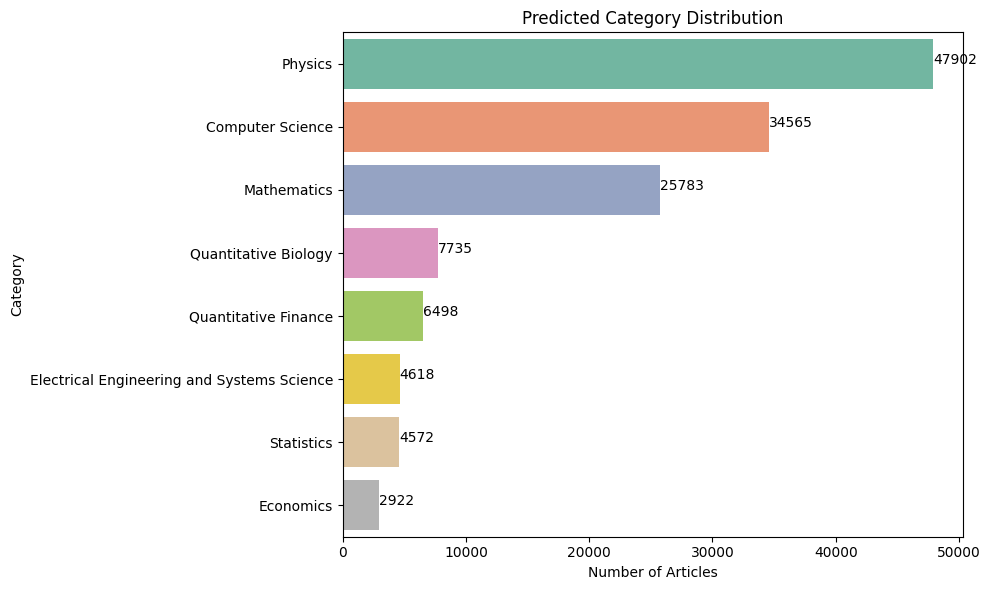

C:\Users\andre\AppData\Local\Temp\ipykernel_52120\1299950009.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keywords.values, y=keywords.index, palette="coolwarm")


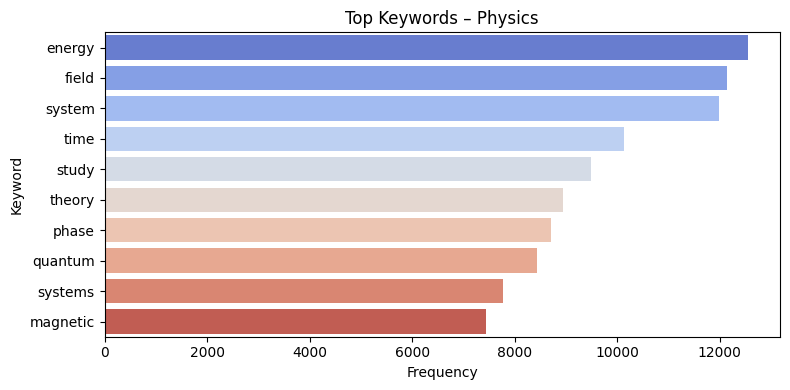

C:\Users\andre\AppData\Local\Temp\ipykernel_52120\1299950009.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keywords.values, y=keywords.index, palette="coolwarm")


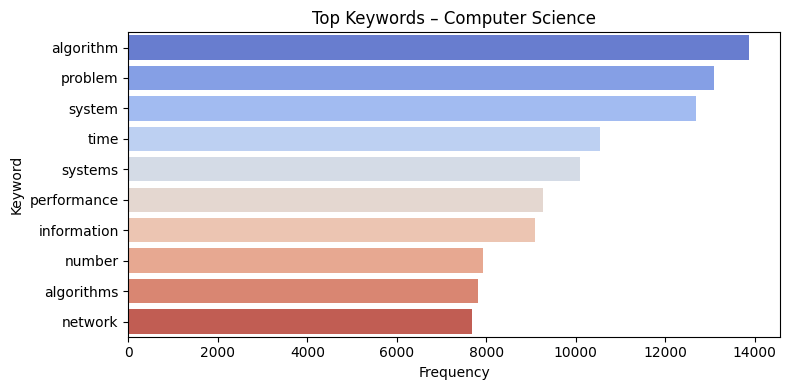

C:\Users\andre\AppData\Local\Temp\ipykernel_52120\1299950009.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keywords.values, y=keywords.index, palette="coolwarm")


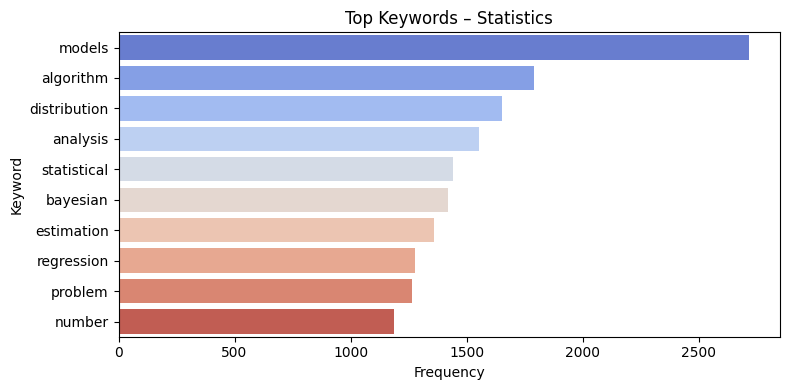

C:\Users\andre\AppData\Local\Temp\ipykernel_52120\1299950009.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keywords.values, y=keywords.index, palette="coolwarm")


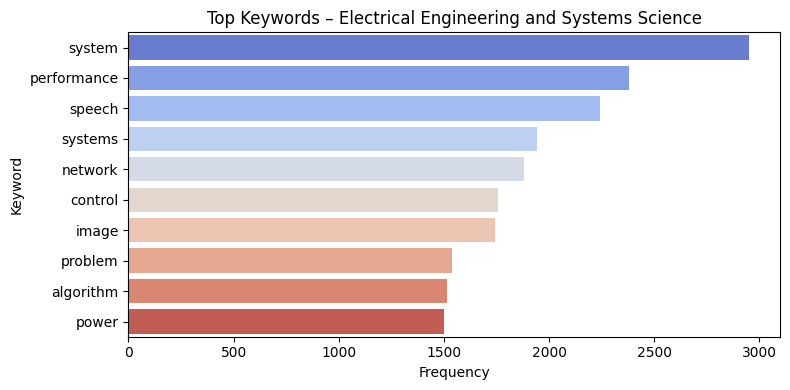

C:\Users\andre\AppData\Local\Temp\ipykernel_52120\1299950009.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keywords.values, y=keywords.index, palette="coolwarm")


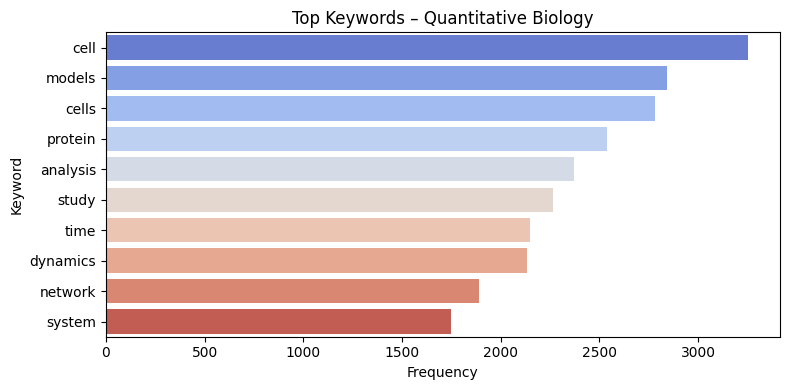

C:\Users\andre\AppData\Local\Temp\ipykernel_52120\1299950009.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keywords.values, y=keywords.index, palette="coolwarm")


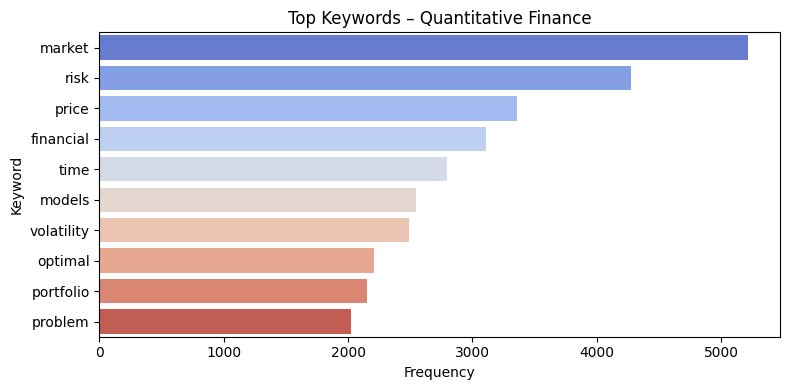

C:\Users\andre\AppData\Local\Temp\ipykernel_52120\1299950009.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keywords.values, y=keywords.index, palette="coolwarm")


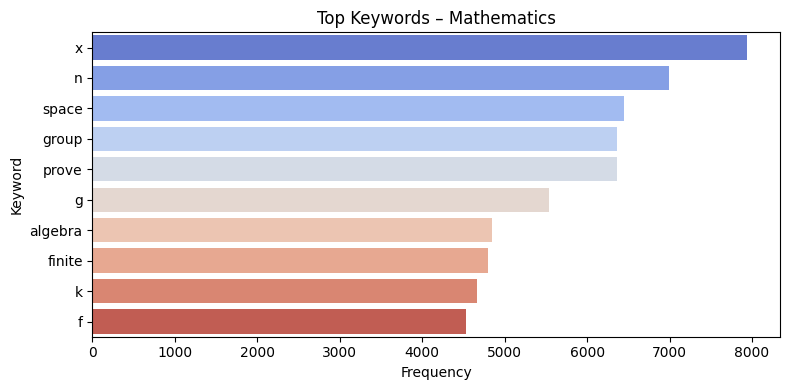

C:\Users\andre\AppData\Local\Temp\ipykernel_52120\1299950009.py:162: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=keywords.values, y=keywords.index, palette="coolwarm")


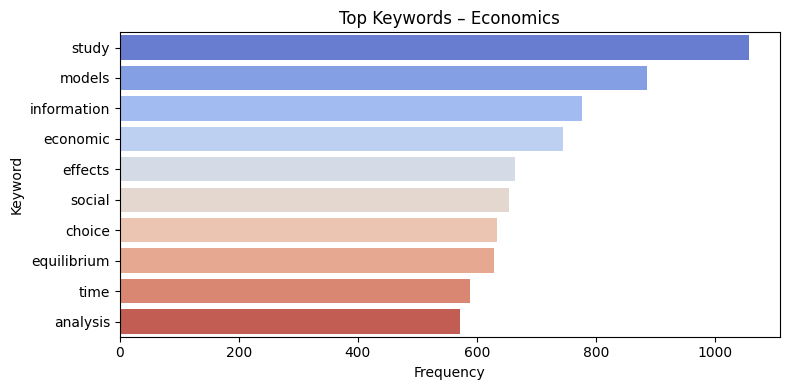

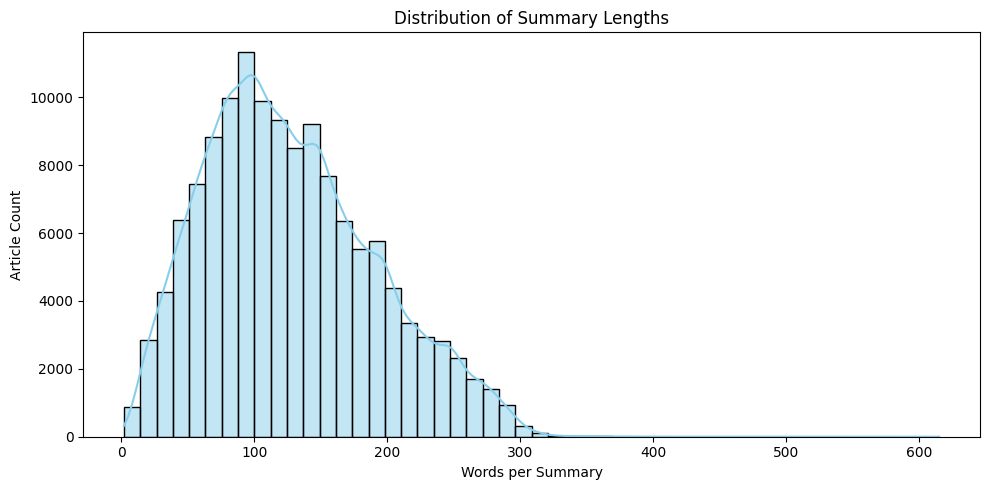

C:\Users\andre\AppData\Local\Temp\ipykernel_52120\1299950009.py:181: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x="Predicted_Category", y="Summary_Length", palette="Set3")


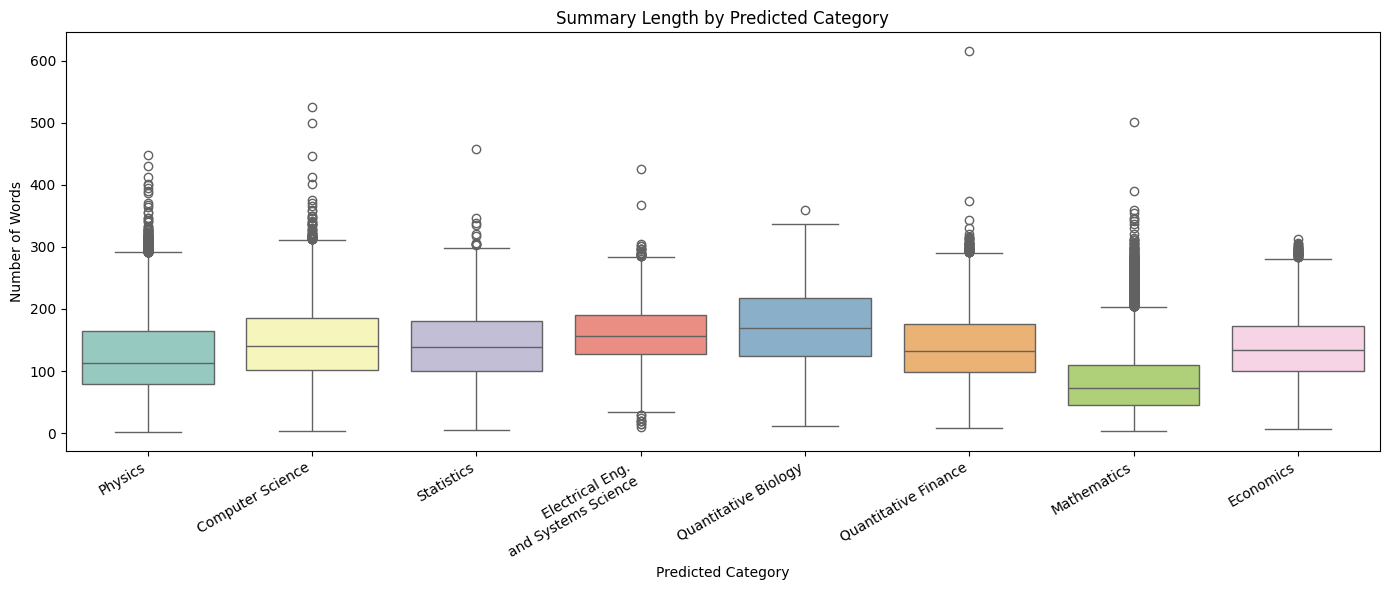

C:\Users\andre\AppData\Local\Temp\ipykernel_52120\1299950009.py:195: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=df, x="Predicted_Category", y="Summary_Length", palette="pastel")


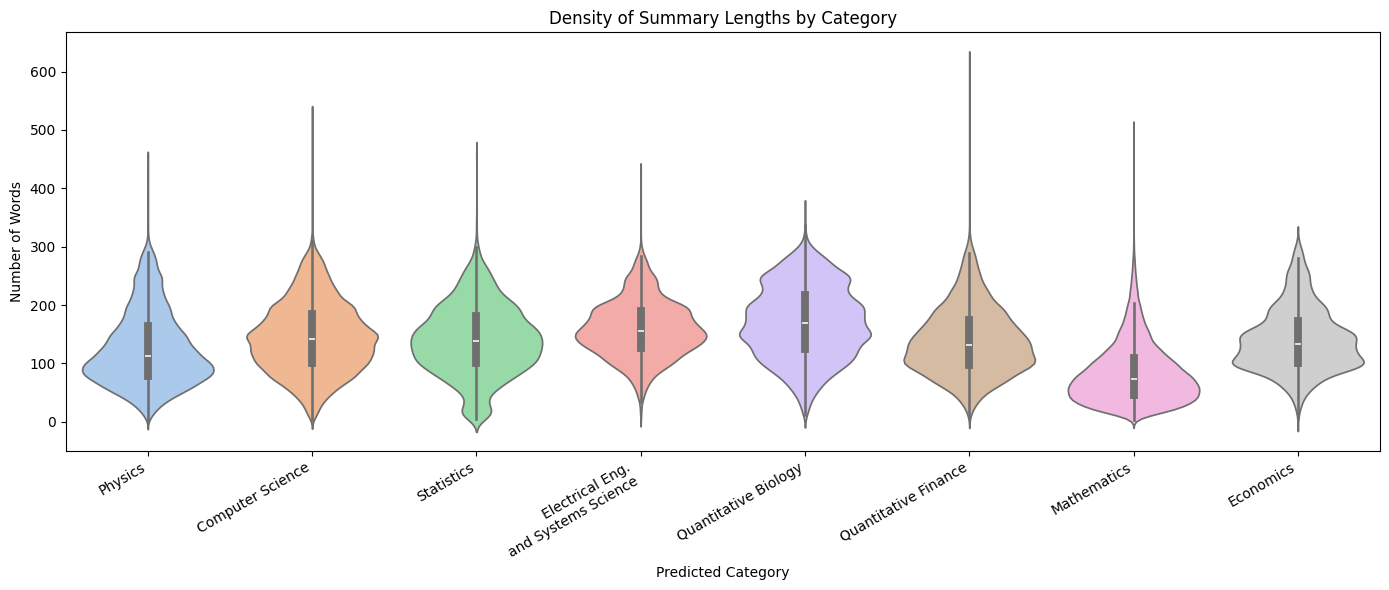

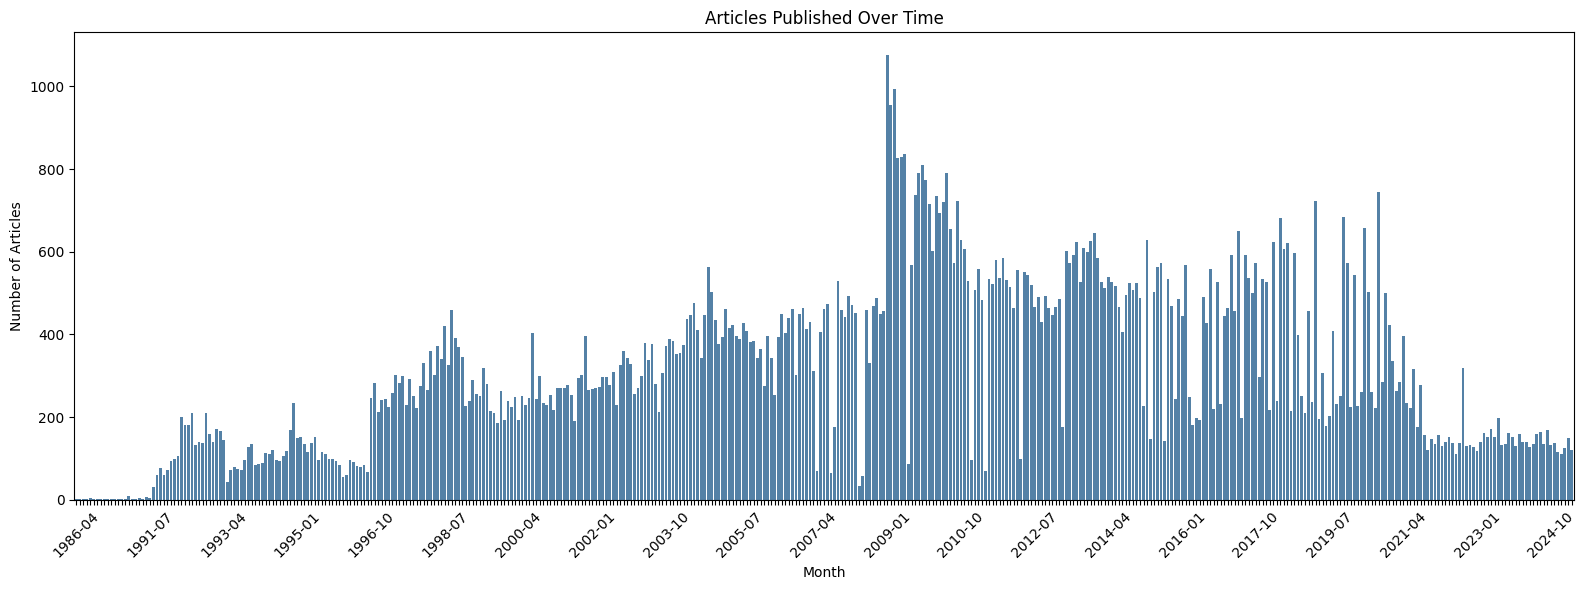

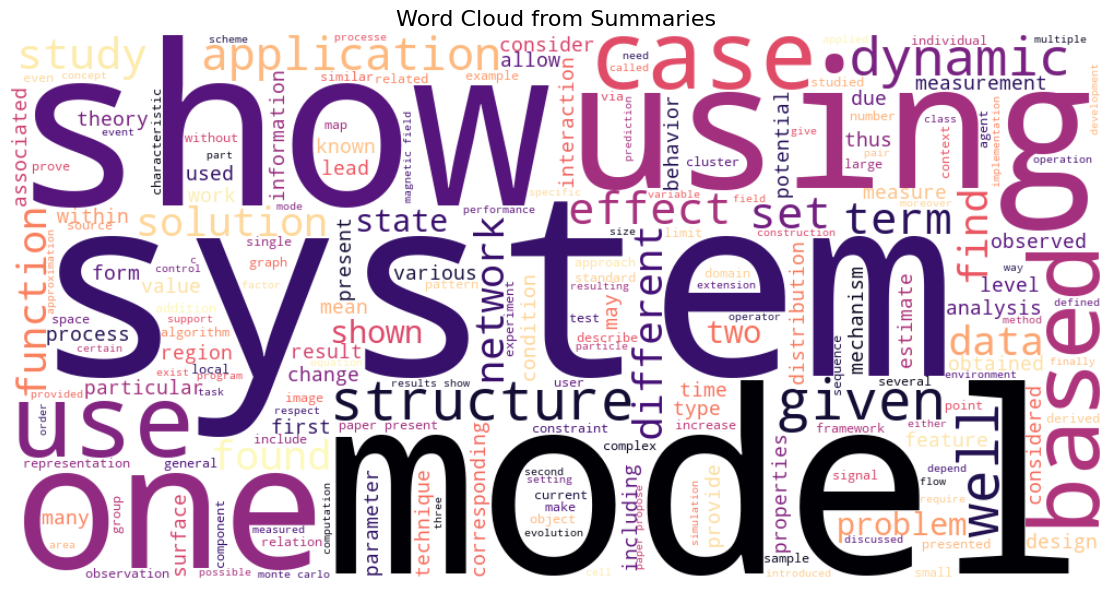

In [48]:
# ========================== INSTALL DEPENDENCIES ==========================
!pip install torch transformers pandas matplotlib seaborn openpyxl tqdm scikit-learn wordcloud
!pip install nltk==3.8.1

import os, json, torch
import shutil, sys, subprocess
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from collections import Counter
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelBinarizer
from wordcloud import WordCloud

# ========================== CLEAN NLTK SETUP ==========================
subprocess.run([sys.executable, "-m", "pip", "uninstall", "-y", "nltk"], check=True)
shutil.rmtree("C:/Users/andre/nltk_data", ignore_errors=True)
if "nltk" in sys.modules:
    del sys.modules["nltk"]
subprocess.run([sys.executable, "-m", "pip", "install", "nltk==3.8.1", "--no-cache-dir"], check=True)

import nltk
nltk.download("punkt", download_dir="C:/Users/andre/nltk_data")
nltk.download("stopwords", download_dir="C:/Users/andre/nltk_data")
nltk.data.path.append("C:/Users/andre/nltk_data")

from nltk.tokenize.punkt import PunktSentenceTokenizer, PunktParameters
import nltk.tokenize

def _patched_get_punkt_tokenizer(language="english"):
    punkt_param = PunktParameters()
    return PunktSentenceTokenizer(punkt_param)

nltk.tokenize._get_punkt_tokenizer = _patched_get_punkt_tokenizer

from nltk.tokenize import word_tokenize
print("Tokenizer working:", word_tokenize("This should finally work now."))

from nltk.corpus import stopwords
stop_words = set(stopwords.words("english"))

# ========================== SETUP PATHS ==========================
model_path = "fine_tuned_distilbert"
label_map_file = "label_mapping.json"
batch_folder = r"C:\\Users\\andre\\Downloads\\saved_data"
output_dir = "C:/Users/andre/Documents/llm_plot_exports"
os.makedirs(output_dir, exist_ok=True)

# ========================== LOAD MODEL AND TOKENIZER ==========================
tokenizer = DistilBertTokenizerFast.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

with open(label_map_file, "r") as f:
    id_to_label = {int(k): v for k, v in json.load(f).items()}
label_to_id = {v: k for k, v in id_to_label.items()}

# ========================== LOAD DATA ==========================
all_records = []
for file in os.listdir(batch_folder):
    if file.endswith(".txt"):
        with open(os.path.join(batch_folder, file), encoding="utf-8") as f:
            for line in f:
                if line.strip():
                    record = json.loads(line)
                    if "summary" in record:
                        record["batch_file"] = file
                        all_records.append(record)

print(f"Loaded {len(all_records)} records.")

# ========================== INFERENCE ==========================
titles, summaries, predicted_labels, true_labels, published_dates, batch_files = [], [], [], [], [], []

print("Running inference on summaries...")
for rec in tqdm(all_records, desc="Inference Progress", unit="record"):
    summary = rec["summary"]
    title = rec.get("title", "")
    published = rec.get("published", "")[:10]
    batch = rec.get("batch_file", "")

    titles.append(title)
    summaries.append(summary)
    published_dates.append(published)
    batch_files.append(batch)

    if "main_category" in rec:
        true_labels.append(rec["main_category"])

    inputs = tokenizer(summary, return_tensors="pt", truncation=True, padding=True, max_length=512)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    with torch.no_grad():
        logits = model(**inputs).logits
        pred = torch.argmax(logits, dim=-1).item()
        predicted_labels.append(id_to_label[pred])

# ========================== CREATE DATAFRAME ==========================
df = pd.DataFrame({
    "Title": titles,
    "Summary": summaries,
    "Predicted_Category": predicted_labels,
    "Published_Date": published_dates,
    "Batch_File": batch_files
})
if true_labels:
    df["True_Category"] = true_labels

# ========================== EXPORT TO EXCEL ==========================
df.to_excel("llm_predictions.xlsx", index=False)
print("Saved: llm_predictions.xlsx")

# ========================== METRICS ==========================
if true_labels:
    accuracy = accuracy_score(true_labels, predicted_labels)
    print(f"Accuracy: {accuracy:.3f}")

    lb = LabelBinarizer()
    true_bin = lb.fit_transform(true_labels)
    pred_bin = lb.transform(predicted_labels)
    auc = roc_auc_score(true_bin, pred_bin, average="macro") if true_bin.shape[1] > 1 else roc_auc_score(true_bin, pred_bin)
    print(f"ROC AUC (macro): {auc:.3f}")

# ========================== VISUALIZATIONS ==========================
plt.figure(figsize=(10, 6))
category_counts = df["Predicted_Category"].value_counts()
sns.barplot(y=category_counts.index, x=category_counts.values, palette="Set2")
for index, value in enumerate(category_counts.values):
    plt.text(value, index, str(value))
plt.title("Predicted Category Distribution")
plt.xlabel("Number of Articles")
plt.ylabel("Category")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "predicted_category_distribution.png"))
plt.show()

custom_stopwords = stop_words.union({
    'using', 'also', 'two', 'show', 'result', 'results', 'data', 'model', 
    'used', 'use', 'paper', 'present', 'based', 'approach', 'method', 'methods',
    'proposed', 'one', 'we', 'can', 'may', 'new', 'provide', 'different'
})

def get_top_keywords(texts, n=10):
    all_words = []
    for text in texts:
        words = word_tokenize(text.lower(), preserve_line=False)
        words = [w for w in words if w.isalpha() and w not in custom_stopwords]
        all_words.extend(words)
    return pd.Series(Counter(all_words)).nlargest(n)

top_keywords = {}
for cat in df["Predicted_Category"].unique():
    summaries_cat = df[df["Predicted_Category"] == cat]["Summary"].dropna().tolist()
    top_keywords[cat] = get_top_keywords(summaries_cat)

for i, (cat, keywords) in enumerate(top_keywords.items()):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=keywords.values, y=keywords.index, palette="coolwarm")
    plt.title(f"Top Keywords – {cat}")
    plt.xlabel("Frequency")
    plt.ylabel("Keyword")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"top_keywords_{i}_{cat}.png"))
    plt.show()

df["Summary_Length"] = df["Summary"].apply(lambda s: len(s.split()))
plt.figure(figsize=(10, 5))
sns.histplot(df["Summary_Length"], bins=50, kde=True, color="skyblue")
plt.title("Distribution of Summary Lengths")
plt.xlabel("Words per Summary")
plt.ylabel("Article Count")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "summary_length_distribution.png"))
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(data=df, x="Predicted_Category", y="Summary_Length", palette="Set3")
new_labels = [
    label.replace("Electrical Engineering and Systems Science", "Electrical Eng.\nand Systems Science")
    for label in df["Predicted_Category"].unique()
]
plt.xticks(ticks=range(len(new_labels)), labels=new_labels, rotation=30, ha='right')
plt.title("Summary Length by Predicted Category")
plt.xlabel("Predicted Category")
plt.ylabel("Number of Words")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "boxplot_summary_lengths.png"))
plt.show()

plt.figure(figsize=(14, 6))
sns.violinplot(data=df, x="Predicted_Category", y="Summary_Length", palette="pastel")
wrapped_labels = [
    label.replace("Electrical Engineering and Systems Science", "Electrical Eng.\nand Systems Science")
    for label in df["Predicted_Category"].unique()
]
plt.xticks(ticks=range(len(wrapped_labels)), labels=wrapped_labels, rotation=30, ha='right')
plt.title("Density of Summary Lengths by Category")
plt.xlabel("Predicted Category")
plt.ylabel("Number of Words")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "violin_summary_lengths.png"))
plt.show()

df["Published_Date"] = pd.to_datetime(df["Published_Date"], errors='coerce')
date_counts = df["Published_Date"].dropna().dt.to_period("M").value_counts().sort_index()
date_counts.index = date_counts.index.astype(str)

plt.figure(figsize=(16, 6))
ax = sns.barplot(x=date_counts.index, y=date_counts.values, color="steelblue")
plt.title("Articles Published Over Time")
plt.xlabel("Month")
plt.ylabel("Number of Articles")
step = max(len(date_counts) // 20, 1)
for idx, label in enumerate(ax.get_xticklabels()):
    label.set_rotation(45)
    label.set_visible(idx % step == 0)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "articles_published_over_time.png"))
plt.show()

all_words = " ".join([
    word for summary in df["Summary"]
    for word in word_tokenize(summary.lower())
    if word.isalpha() and word not in stop_words
])
wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='magma').generate(all_words)
plt.figure(figsize=(14, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud from Summaries", fontsize=16)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "word_cloud.png"))
plt.show()
